<a href="https://colab.research.google.com/github/AlekseiMikhalev/Data-Science-Projects/blob/master/ULMFiT_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#__ULMFiT tweets sentiment analysis__

In [0]:
#Importing Libraries 

from fastai.metrics import accuracy #explain why?
from fastai.text import * #explain why?
from fastai import * #explain why?
import gc #explain why?
import os #explain why?
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np #linear algebra
import matplotlib.pyplot as plt #library for visualization 

In [2]:
#Open the dataset and explore it
tweets = pd.read_csv('/content/Tweets.csv')
print('Shape: ', tweets.shape) #check the shape of the dataframe
tweets.head()

Shape:  (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
#Let's check missing data in each column
def check_missing_data(df):
  # check for any missing data in the df (sort in descending order)
  return df.isnull() | df.isna().sum().sort_values(ascending=False)

In [4]:
check_missing_data(tweets)

,airline,airline_sentiment,airline_sentiment_confidence,airline_sentiment_gold,name,negativereason,negativereason_confidence,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,False,False,False,True,False,True,True,True,False,False,True,False,False,True,True
1,False,False,False,True,False,True,True,True,False,False,True,False,False,True,True
2,False,False,False,True,False,True,True,True,False,False,True,False,False,True,True
3,False,False,False,True,False,True,True,True,False,False,True,False,False,True,True
4,False,False,False,True,False,True,True,True,False,False,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,False,False,False,True,False,True,True,True,False,False,True,False,False,True,True
14636,False,False,False,True,False,True,True,True,False,False,True,False,False,True,True
14637,False,False,False,True,False,True,True,True,False,False,True,False,False,True,True
14638,False,False,False,True,False,True,True,True,False,False,True,False,False,True,True


In [5]:
#Calculate the percentage of null values in each column and sort in descending order
print("The percentage of null or na values in the dataset")
((tweets.isnull() | tweets.isna()).sum() * 100 / tweets.index.size).round(2).sort_values(ascending=False)

The percentage of null or na values in the dataset


negativereason_gold             99.78
airline_sentiment_gold          99.73
tweet_coord                     93.04
negativereason                  37.31
user_timezone                   32.92
tweet_location                  32.33
negativereason_confidence       28.13
tweet_created                    0.00
text                             0.00
retweet_count                    0.00
name                             0.00
airline                          0.00
airline_sentiment_confidence     0.00
airline_sentiment                0.00
tweet_id                         0.00
dtype: float64

In [0]:
#Droping top 3 columns with the highest percentage of missing values
tweets = tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'])

###__Data visualization__

*Visualize the total number of tweets per each airlines*

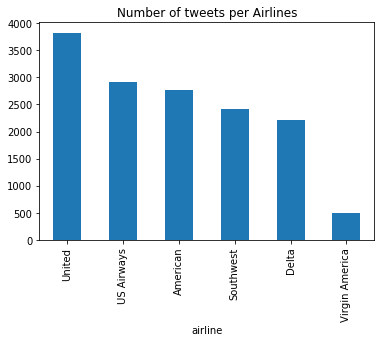

In [7]:
tweets.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False).plot(kind='bar')
plt.title('Number of tweets per Airlines')
plt.show()

*Tweet sentiments per each airlines*

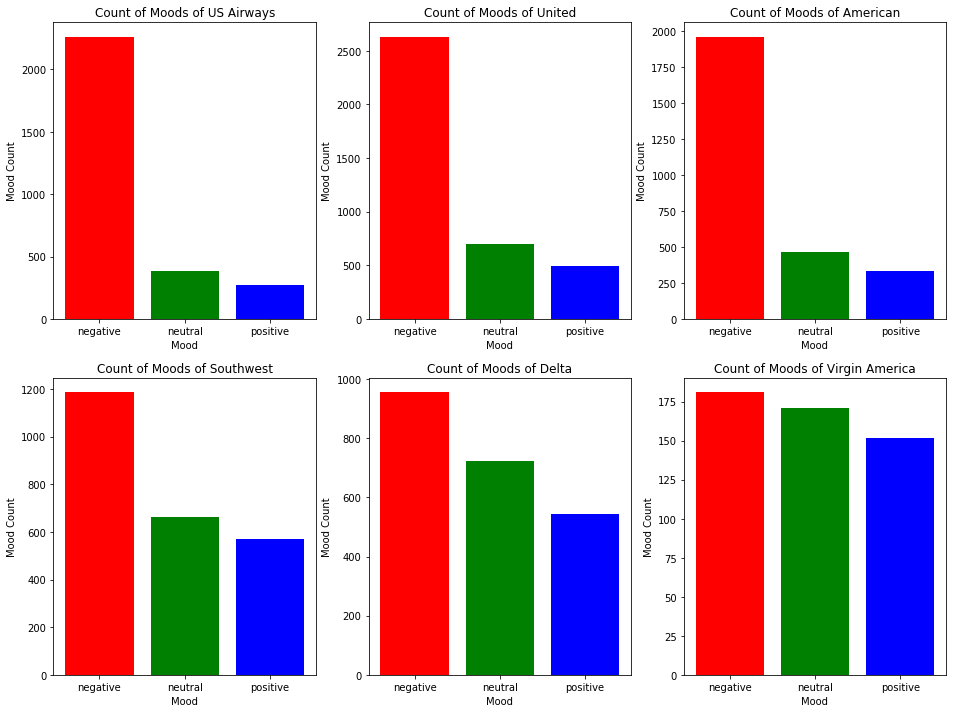

In [8]:
#Let's plot bar charts that show the number of tweets in each sentiment group per airlines
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']

plt.figure(1,figsize=(16, 12))
for i in airlines:
    indices = airlines.index(i)
    plt.subplot(2, 3, indices+1)
    new_df=tweets[tweets['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1, 2, 3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

###__Wordclouds__ of the __Positive__, __Negative__, __Neutral__ - airline_sentiment

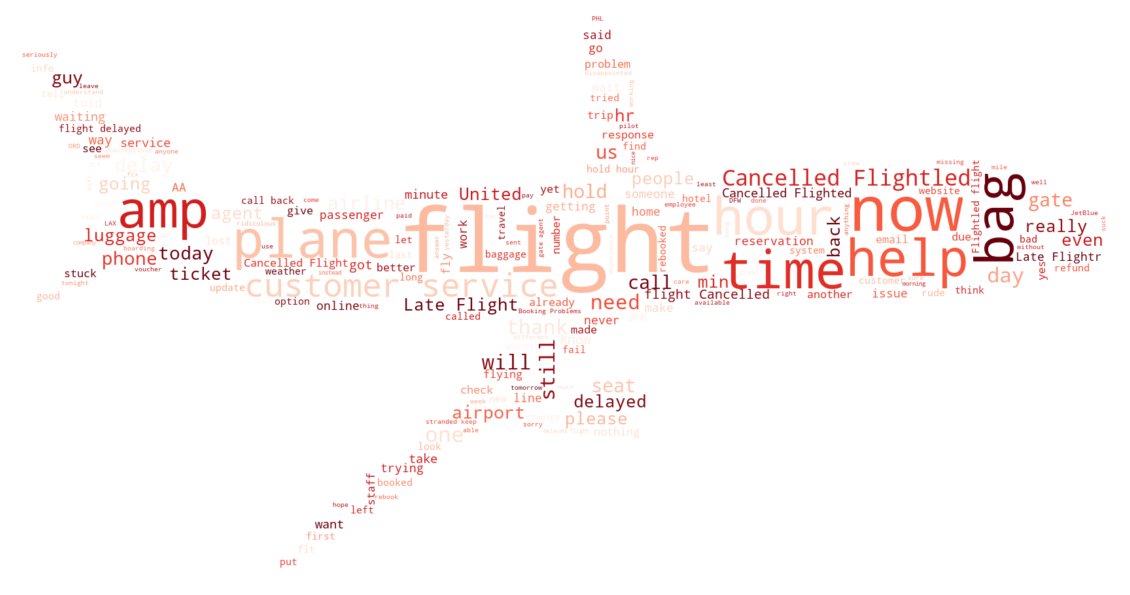

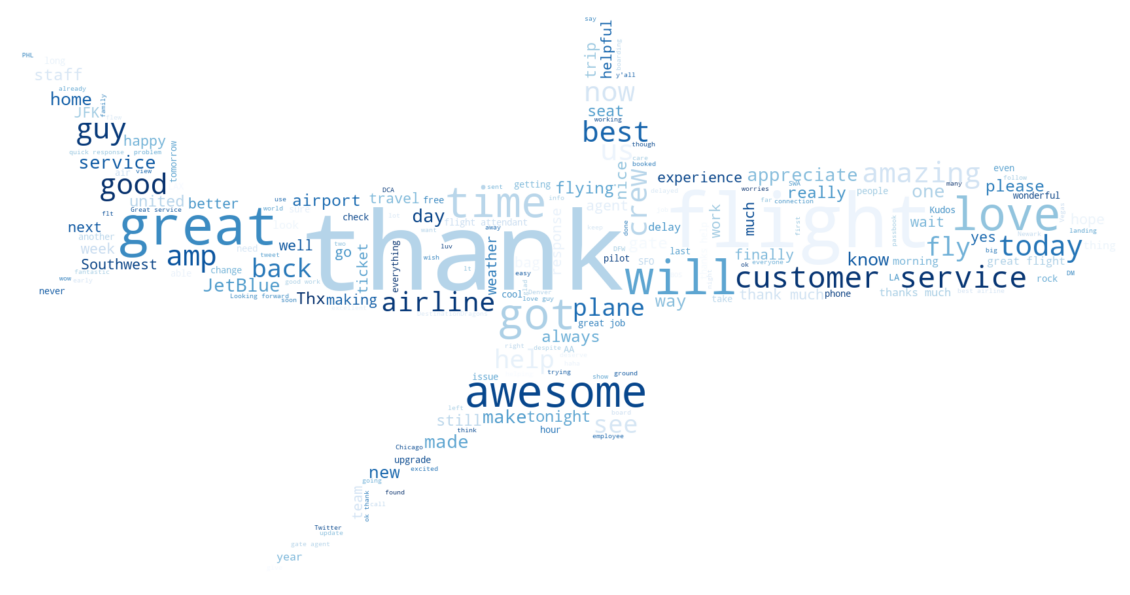

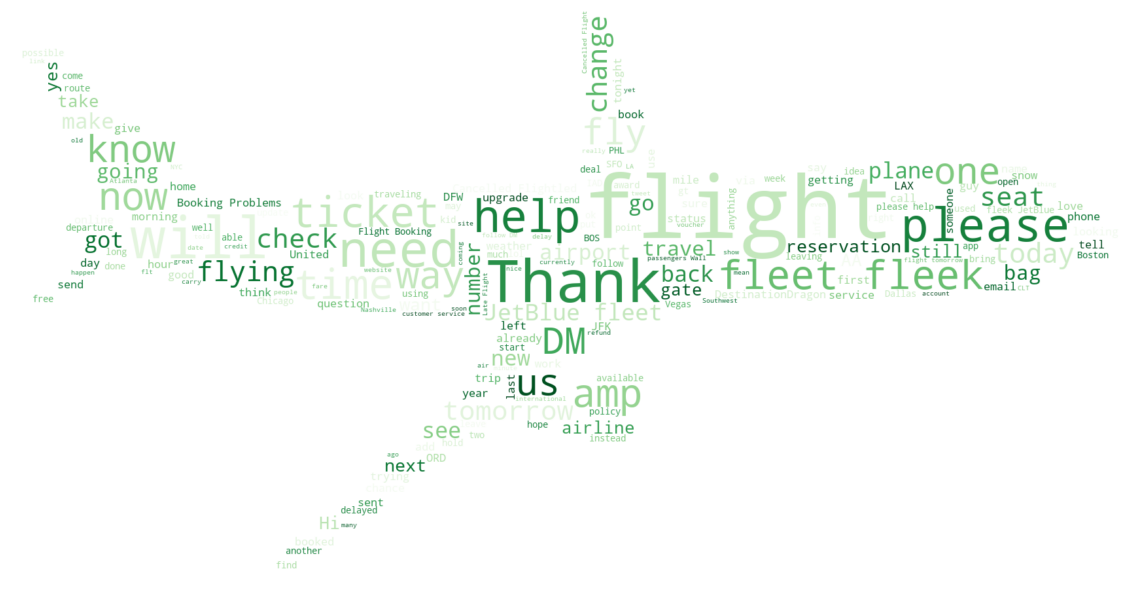

In [9]:
from wordcloud import WordCloud,STOPWORDS  #WordCloud is used for data visualization. The size of each word indicates its frequency or importance.
from PIL import Image # to import the image for the shape 
wave_mask = np.array(Image.open( "/content/airbus.jpg"))

#Positive sentiments
words_positive = ' '.join(tweets[tweets['airline_sentiment']=='positive']['text'])
cleaned_word_positive = " ".join([word for word in words_positive.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
#Negative sentiments
words_negative = ' '.join(tweets[tweets['airline_sentiment']=='negative']['text'])
cleaned_word_negative = " ".join([word for word in words_negative.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
#Neutral sentiments
words_neutral = ' '.join(tweets[tweets['airline_sentiment']=='neutral']['text'])
cleaned_word_neutral = " ".join([word for word in words_neutral.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud_negative = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Reds",  width=2048, height=2048).generate(cleaned_word_negative)
plt.figure(1,figsize=(20, 14))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud_positive = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Blues", width=2048, height=2048).generate(cleaned_word_positive)
plt.figure(1,figsize=(20, 14))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud_neutral = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Greens", width=2048, height=2048).generate(cleaned_word_neutral)
plt.figure(1,figsize=(20, 14))
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [32]:
negative_tokenized_tweets = []
positive_tokenized_tweets = []
neutral_tokenized_tweets = []
negative = cleaned_word_negative.split()
positive = cleaned_word_positive.split()
neutral = cleaned_word_neutral.split()
from nltk import flatten

for i in negative: 
  tokens = nltk.word_tokenize(i)
  negative_tokenized_tweets.append(tokens)
negative_tokenized_tweets = flatten(negative_tokenized_tweets)

for i in positive: 
  tokens = nltk.word_tokenize(i)
  positive_tokenized_tweets.append(tokens)
positive_tokenized_tweets = flatten(positive_tokenized_tweets)

for i in neutral: 
  tokens = nltk.word_tokenize(i)
  neutral_tokenized_tweets.append(tokens)
neutral_tokenized_tweets = flatten(neutral_tokenized_tweets)

print(negative_tokenized_tweets[0:9])
print(positive_tokenized_tweets[0:9])
print(neutral_tokenized_tweets[0:9])

['it', "'s", 'really', 'aggressive', 'to', 'blast', 'obnoxious', '``', 'entertainment']
['plus', 'you', "'ve", 'added', 'commercials', 'to', 'the', 'experience', '...']
['What', 'said', '.', 'I', 'did', "n't", 'today', '...', 'Must']


In [33]:
#Remove stopwords and punctuation from the lists of tweets
import string
negative_without_stopwords = []
positive_without_stopwords = []
neutral_without_stopwords = []

for w in negative_tokenized_tweets:
  if w not in stop_words | set(string.punctuation):
    negative_without_stopwords.append(w)

for w in positive_tokenized_tweets:
  if w not in stop_words | set(string.punctuation):
    positive_without_stopwords.append(w)

for w in neutral_tokenized_tweets:
  if w not in stop_words | set(string.punctuation):
    neutral_without_stopwords.append(w)

print('Negative \n', negative_without_stopwords[0:9],'\n Positive \n', positive_without_stopwords[0:9],'\n Neutral \n', neutral_without_stopwords[0:9])

Negative 
 ["'s", 'really', 'aggressive', 'blast', 'obnoxious', '``', 'entertainment', "''", 'guests'] 
 Positive 
 ['plus', "'ve", 'added', 'commercials', 'experience', '...', 'tacky', 'yes', 'nearly'] 
 Neutral 
 ['What', 'said', 'I', "n't", 'today', '...', 'Must', 'mean', 'I']


In [13]:
from collections import Counter 
freq_negative = Counter(negative_without_stopwords)
freq_positive = Counter(positive_without_stopwords)
freq_neutral = Counter(neutral_without_stopwords)

#Create dataframes in pandas with two columns and sort it by frequency
freq_negative = pd.DataFrame(freq_negative.most_common(50), columns=['words_negative', 'count'])
freq_negative.sort_values(ascending=False, by='count')

freq_positive = pd.DataFrame(freq_positive.most_common(50), columns=['words_positive', 'count'])
freq_positive.sort_values(ascending=False, by='count')

freq_neutral = pd.DataFrame(freq_neutral.most_common(50), columns=['words_neutral', 'count'])
freq_neutral.sort_values(ascending=False, by='count')

print('Negative \n', freq_negative.head(), '\n Positive \n', freq_positive.head(), '\n Neutral \n', freq_neutral.head())

Negative 
   words_negative  count
0              I   4318
1         flight   2336
2            n't   1759
3            get    949
4      Cancelled    920 
 Positive 
   words_positive  count
0              I    713
1         flight    326
2         thanks    320
3         Thanks    283
4          Thank    231 
 Neutral 
   words_neutral  count
0             I   1315
1        flight    495
2            's    359
3           get    235
4           n't    199


In [14]:
#It seems like we have many of "I" in the data sets, however it doesn't have any values, so we get rid of it too
stopword = "I"
for w in negative_without_stopwords:
  if w in stopword:
    negative_without_stopwords.remove(w)

for w in positive_without_stopwords:
  if w in stopword:
    positive_without_stopwords.remove(w)

for w in neutral_without_stopwords:
  if w in stopword:
    neutral_without_stopwords.remove(w)

#Create counter again
freq_negative = Counter(negative_without_stopwords)
freq_positive = Counter(positive_without_stopwords)
freq_neutral = Counter(neutral_without_stopwords)

#Create dataframes again
freq_negative = pd.DataFrame(freq_negative.most_common(50), columns=['words_negative', 'count'])
freq_negative.sort_values(ascending=False, by='count')

freq_positive = pd.DataFrame(freq_positive.most_common(50), columns=['words_positive', 'count'])
freq_positive.sort_values(ascending=False, by='count')

freq_neutral = pd.DataFrame(freq_neutral.most_common(50), columns=['words_neutral', 'count'])
freq_neutral.sort_values(ascending=False, by='count')

print('Negative \n', freq_negative.head(), '\n Positive \n', freq_positive.head(), '\n Neutral \n', freq_neutral.head())

Negative 
   words_negative  count
0         flight   2336
1            n't   1759
2            get    949
3      Cancelled    920
4             's    903 
 Positive 
   words_positive  count
0         flight    326
1         thanks    320
2         Thanks    283
3          Thank    231
4          thank    204 
 Neutral 
   words_neutral  count
0        flight    495
1            's    359
2           get    235
3           n't    199
4           ...    182


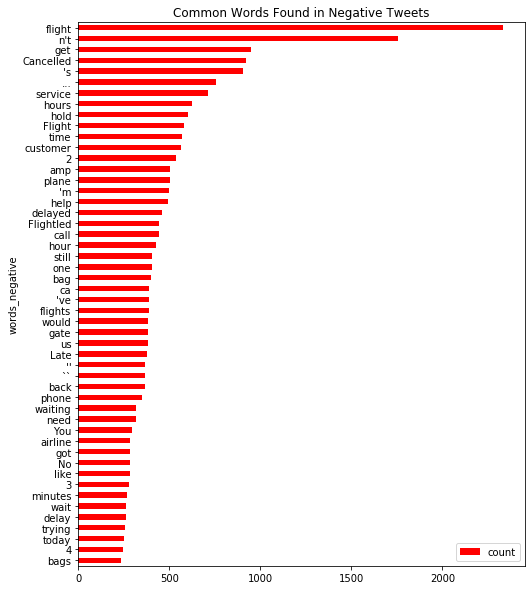

In [15]:
#Let's plot the results to check it visually
fig, ax = plt.subplots(figsize=(8, 10))

#Plot horizontal bar graph
#For negative words
freq_negative.sort_values(by='count').plot.barh(x='words_negative', y='count', ax=ax, color="red")
ax.set_title("Common Words Found in Negative Tweets")
plt.show()

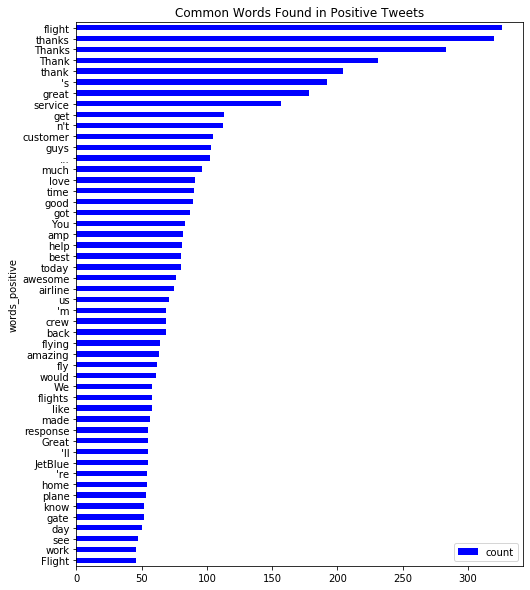

In [16]:
#For positive words
fig, ax = plt.subplots(figsize=(8, 10))
freq_positive.sort_values(by='count').plot.barh(x='words_positive', y='count', ax=ax, color="blue")
ax.set_title("Common Words Found in Positive Tweets")
plt.show()

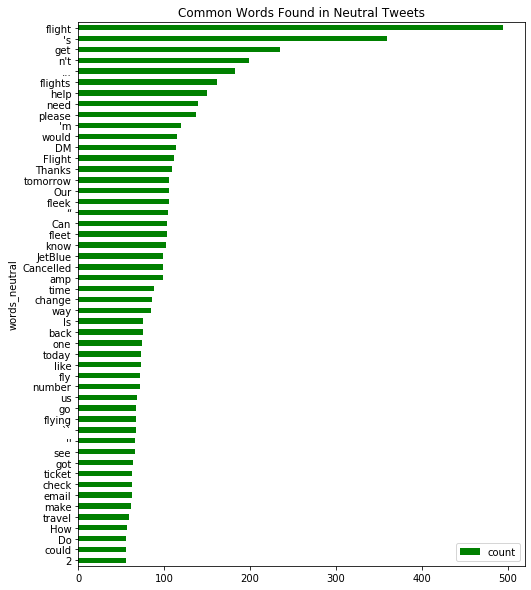

In [17]:
#For neutral words
fig, ax = plt.subplots(figsize=(8, 10))
freq_neutral.sort_values(by='count').plot.barh(x='words_neutral', y='count', ax=ax, color="green")
ax.set_title("Common Words Found in Neutral Tweets")
plt.show()

###__Explore the negative reasons__

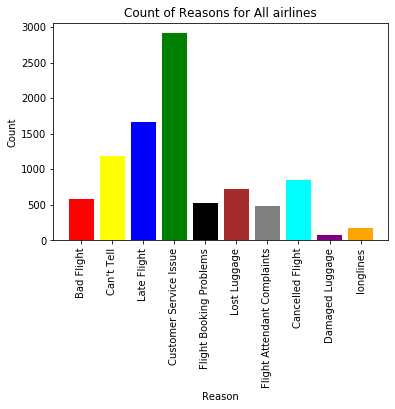

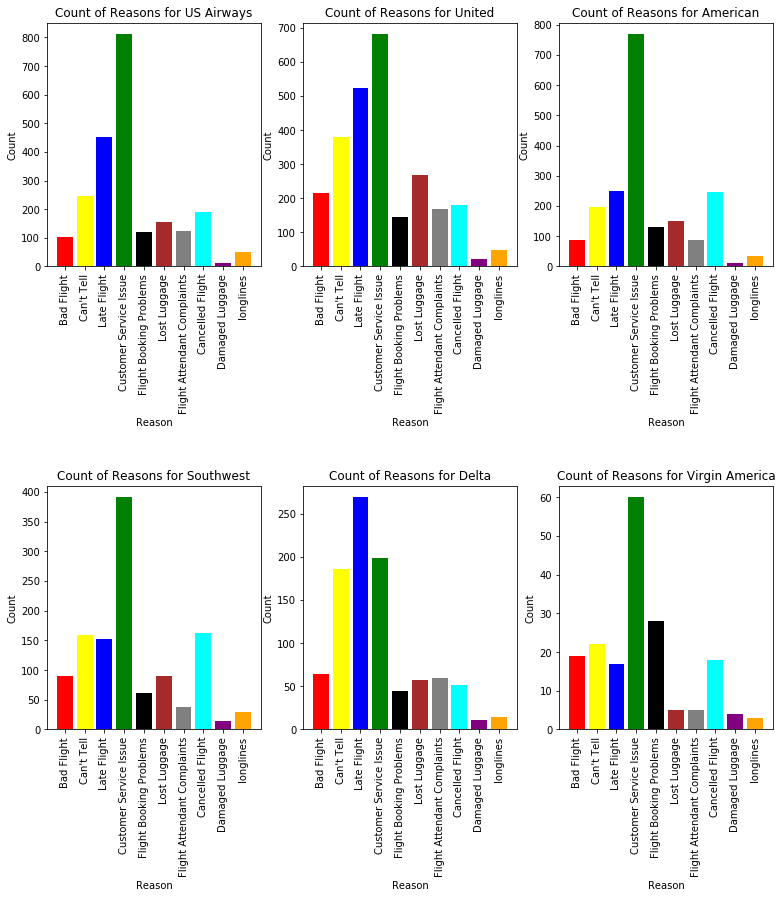

In [18]:
#Get the number of negative reasons
tweets['negativereason'].nunique()

NR_Count=dict(tweets['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All airlines':
        a=tweets
    else:
        a=tweets[tweets['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(tweets['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index, a['Reasons'], rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All airlines')
plt.figure(2, figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2, 3, indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

###__Explore if there are any relashionships between time and tweets__

In [19]:
date = tweets.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
tweets = date
day_df = tweets.groupby(['tweet_created','airline','airline_sentiment']).size()
day_df


tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

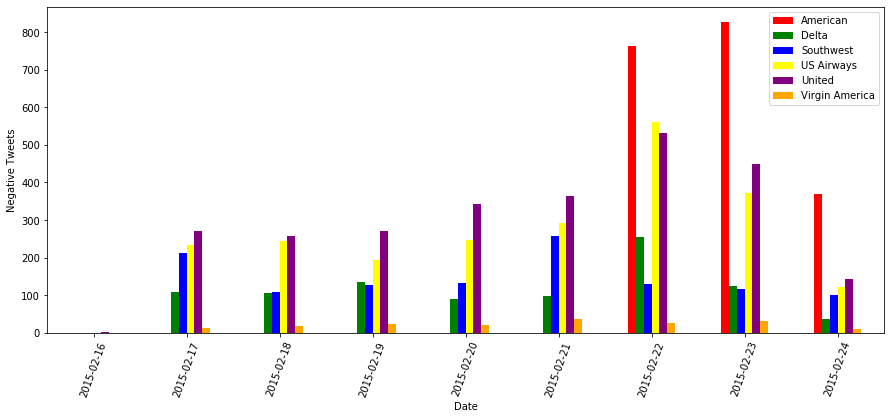

In [20]:
#Now we can plot it and see if we can get any interesting insights about negative tweets

day_df = day_df.loc(axis=0)[:, :, 'negative']

#Groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue', 'yellow', 'purple', 'orange'], figsize = (15, 6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

###__Data Cleaning for ULMFiT__
![image.png](https://humboldt-wi.github.io/blog/img/seminar/group4_ULMFiT/Figure_3.png)

Source: https://humboldt-wi.github.io/blog/research/information_systems_1819/group4_ulmfit/

1. Tokenize
2. Since ULMFiT model is already trained on the WikiText-103 dataset, there is a list of all unique tokens in the dataset, ordered from most often to least often used as well as the same information formatted as a dictionary. Thus loading this vocabulary and dictionary enables us to encode our tweets text accordingly.
3. 

In [29]:
#Define the sample of a tweet
sample = tweets['text']
#load pretrained wikipedia vocabulary with all tokens
with open('!cp ../input/wt103-fastai-nlp/itos_wt103.pkl ~/.fastai/models/wt103-fwd/') as pickle_file:
    itos_wiki = pickle.load(pickle_file)

#assign every token a individual number
stoi_wiki = collections.defaultdict(lambda:-1, {v:k for k,v 
                                              in enumerate(itos_wiki)})

list(stoi_wiki.items())[0:10]

FileNotFoundError: ignored

In [0]:
#Let's check the text of the tweets
pd.set_option('display.max_colwidth', 1000)
tweets['text'].head(30)

0                                                                                                              @VirginAmerica What @dhepburn said.
1                                                                         @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                          @VirginAmerica I didn't today... Must mean I need to take another trip!
3                   @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                          @VirginAmerica and it's a really big bad thing about it
5         @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6                                                                  @VirginAmerica yes, nearly every time I fly VX this

####__Plan of data cleaning:__
  1. Think of @user, it is hardly giving any information about the nature of the tweet.
  2. Same about the punctuations, numbers and even special characters since they wouldn’t help in differentiating different kinds of tweets.
  3. Most of the smaller words and stopwords that do not add much value. For example, ‘pdx’, ‘his’, ‘all’. Based on wordcloud analysis there are many words like this. 
  4. Split every tweet into individual words or tokens which is an essential step in any NLP task.
  5. In the 4th tweet, there is a word ‘love’. We might also have terms like loves, loving, lovable, etc. in the rest of the data. These terms are often used in the same context. If we can reduce them to their root word, which is ‘love’, then we can reduce the total number of unique words in our data without losing a significant amount of information.

In [0]:
import re #Explain why import this?
import nltk #And this
nltk.download('stopwords')
from nltk.corpus import stopwords #And this and each function below

def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

tweets['clean_tweet']=tweets['text'].apply(lambda x: tweet_to_words(x))
tweets['Tweet_length']=tweets['text'].apply(lambda x: clean_tweet_length(x))
tweets['sentiment']=tweets['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

#Split data into training and validation set
df_trn, df_val = train_test_split(tweets, stratify = tweets['airline_sentiment'], test_size = 0.4, random_state = 678) #Explain why 678

###__ULMFiT Model__


In [0]:
#Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [0]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.4) #explain

In [0]:
#Train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2) #Explain why this learning rate has been chosen

epoch,train_loss,valid_loss,accuracy,time
0,5.920623,4.275937,0.474256,00:36


In [0]:
#Unfreeze the learner object and train
learn.unfreeze()
learn.fit_one_cycle(7, slice(1e-2, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.505138,0.482198,0.810714,00:54
1,0.530932,0.489904,0.810863,00:54
2,0.515965,0.476172,0.811533,00:54
3,0.505761,0.469507,0.811533,00:54
4,0.498354,0.470698,0.810714,00:53
5,0.493418,0.469380,0.811161,00:54
6,0.489438,0.469218,0.811161,00:54


In [0]:
learn.save_encoder('ft_enc')